In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Optional
import os
import missingno as msno

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split, cross_val_score, GroupShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder

from src.utils import show_feature_importances

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
pd.options.display.max_columns = 400

### Загрузка датасета

In [3]:
data_path='./data/'

train_data = pd.read_csv(os.path.join(data_path, "train.csv"))
bki_data = pd.read_csv(os.path.join(data_path, "bki.csv"))

print("payments_data.shape = {} rows, {} cols".format(*bki_data.shape))

payments_data.shape = 945234 rows, 17 cols


# Results

In [4]:
bki_data['DAYS_ENDDATE_FACT'][bki_data['DAYS_ENDDATE_FACT'] == 42023] = np.nan
bki_data['DAYS_CREDIT_UPDATE'][bki_data['DAYS_CREDIT_UPDATE'] > 20000] = np.nan
bki_data['DAYS_CREDIT_ENDDATE'][bki_data['DAYS_CREDIT_ENDDATE'] > 20000] = np.nan

In [5]:
bki_data.head(5)

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.81,0,675000.00,320265.495,0.0,0.0,Consumer credit,39.0,NaN
1,123436670,6207544,Closed,currency 1,696.0,0,511.0,511.0,0.00,0,93111.66,0.000,0.0,0.0,Consumer credit,505.0,NaN
2,123589020,6326395,Closed,currency 1,165.0,0,149.0,160.0,NaN,0,36000.00,0.000,0.0,0.0,Consumer credit,150.0,0.0
3,123494590,6606618,Active,currency 1,55.0,0,310.0,NaN,NaN,0,38664.00,37858.500,NaN,0.0,Consumer credit,15.0,NaN
4,123446603,5046832,Active,currency 1,358.0,0,35.0,NaN,NaN,0,67500.00,0.000,0.0,0.0,Credit card,116.0,NaN


In [6]:
bki_data[bki_data['APPLICATION_NUMBER']==123501780]

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
59332,123501780,6232195,Closed,currency 1,2222.0,0,2039.0,2039.0,0.0,0,15574.50,NaN,NaN,0.0,Consumer credit,2018.0,0.0
109395,123501780,6232561,Closed,currency 1,2662.0,0,2082.0,2111.0,0.0,0,69851.97,0.0,0.0,0.0,Consumer credit,2111.0,0.0
337581,123501780,6214504,Closed,currency 1,659.0,0,353.0,345.0,NaN,0,25965.00,0.0,0.0,0.0,Consumer credit,333.0,0.0
422512,123501780,6265084,Closed,currency 1,845.0,0,479.0,479.0,0.0,0,42930.00,0.0,0.0,0.0,Consumer credit,479.0,0.0
495689,123501780,6194657,Active,currency 1,443.0,0,287.0,NaN,NaN,0,283500.00,156532.5,0.0,0.0,Consumer credit,65.0,0.0
903898,123501780,6253771,Active,currency 1,379.0,0,965.0,NaN,NaN,0,135000.00,43164.0,0.0,0.0,Credit card,114.0,0.0


In [7]:
bki_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945234 entries, 0 to 945233
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   APPLICATION_NUMBER      945234 non-null  int64  
 1   BUREAU_ID               945234 non-null  int64  
 2   CREDIT_ACTIVE           945234 non-null  object 
 3   CREDIT_CURRENCY         945234 non-null  object 
 4   DAYS_CREDIT             945234 non-null  float64
 5   CREDIT_DAY_OVERDUE      945234 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     865490 non-null  float64
 7   DAYS_ENDDATE_FACT       596273 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  326557 non-null  float64
 9   CNT_CREDIT_PROLONG      945234 non-null  int64  
 10  AMT_CREDIT_SUM          945229 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     803483 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    619267 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  945234 non-null  float64
 14  CREDIT_TYPE         

In [8]:
bki_data.describe()

,APPLICATION_NUMBER,BUREAU_ID,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,9.452340e+05,9.452340e+05,945234.000000,945234.000000,865490.000000,596273.000000,3.265570e+05,945234.000000,9.452290e+05,8.034830e+05,6.192670e+05,9.452340e+05,945181.000000,2.693300e+05
mean,1.236016e+08,5.974377e+06,1142.218231,0.769791,1118.646184,1017.932427,3.784219e+03,0.006330,3.547738e+05,1.361747e+05,6.267718e+03,3.826128e+01,591.740542,1.646679e+04
std,1.029041e+05,5.330431e+05,795.047305,35.173550,1402.952429,713.039535,2.133823e+05,0.094857,1.078781e+06,6.370282e+05,4.528027e+04,5.156032e+03,651.887524,3.937657e+05
min,1.234233e+08,5.001084e+06,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,0.000000,0.000000e+00
25%,1.235122e+08,5.513773e+06,474.000000,0.000000,372.000000,426.000000,0.000000e+00,0.000000,5.121000e+04,0.000000e+00,0.000000e+00,0.000000e+00,33.000000,0.000000e+00
50%,1.236014e+08,5.976502e+06,987.000000,0.000000,839.000000,897.000000,0.000000e+00,0.000000,1.254708e+05,0.000000e+00,0.000000e+00,0.000000e+00,396.000000,0.000000e+00
75%,1.236908e+08,6.435551e+06,1666.000000,0.000000,1447.000000,1489.000000,0.000000e+00,0.000000,3.150000e+05,3.973275e+04,0.000000e+00,0.000000e+00,908.000000,1.350000e+04
max,1.237796e+08,6.942186e+06,2922.000000,2792.000000,17185.000000,3042.000000,1.159872e+08,7.000000,3.960000e+08,6.544140e+07,4.705600e+06,2.387232e+06,2916.000000,1.184534e+08


In [9]:
# bki_data[bki_data['DAYS_CREDIT_ENDDATE'] > 5000]

In [10]:
for col in bki_data.columns[1:]:
    print(f'{col}: n_uniques:{bki_data[col].nunique()} list:{bki_data[col].unique()}')

BUREAU_ID: n_uniques:743651 list:[5223613 6207544 6326395 ... 5087750 5249714 5445504]
CREDIT_ACTIVE: n_uniques:4 list:['Active' 'Closed' 'Sold' 'Bad debt']
CREDIT_CURRENCY: n_uniques:4 list:['currency 1' 'currency 2' 'currency 3' 'currency 4']
DAYS_CREDIT: n_uniques:2923 list:[ 718.  696.  165. ... 2111. 1978.    0.]
CREDIT_DAY_OVERDUE: n_uniques:606 list:[   0   21  358   13   31    7 1755   68   60   38  113 2693   30   93
  672   49   14    8   23  238   19    6  190  140   29   27   37 1631
    3  326   50   11  951 2426   53  175   56   51    5   15   28   17
  121  936 1724    9  247    2   24    4  100 2684   18   25   34   63
   39 1962   83   42 1715  120 2582  476 1127   90   16 1468 2164   64
 1118 1100  150 1397 2312  691  312    1 2602   33 1939  112   86   26
 1943   97 1682 1541  502   12 1298   22 1503   92  615   54 1363 1514
 1142  743  115  104  220  366 1290   36  641   55   40 2542  242  605
  948 1199   20 1552 1158 2221 1253  953   10  119   58   43   44   73
  

In [11]:
data = bki_data.merge(train_data[['APPLICATION_NUMBER', 'TARGET']], how='left', on='APPLICATION_NUMBER')
data = data.dropna(subset=['TARGET'])
data = data.reset_index(drop=True)

In [12]:
data[['APPLICATION_NUMBER', 'DAYS_CREDIT']].groupby(by='APPLICATION_NUMBER').max()

,DAYS_CREDIT
APPLICATION_NUMBER,
123423341,1437.0
123423352,2070.0
123423355,141.0
123423359,288.0
123423370,501.0
...,...
123730827,1834.0
123730828,994.0
123730830,1524.0


In [13]:
data[data['TARGET']==1].head(30)

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,TARGET
18,123696427,5881270,Active,currency 1,42.0,0,944.0,NaN,0.0,0,67500.000,0.00,0.000,0.0,Credit card,42.0,6750.0,1.0
22,123507968,6173064,Active,currency 1,129.0,0,240.0,NaN,0.0,0,141075.000,141075.00,0.000,0.0,Consumer credit,31.0,NaN,1.0
25,123614726,5310295,Closed,currency 1,1338.0,0,607.0,598.0,NaN,0,568170.000,0.00,NaN,0.0,Consumer credit,380.0,NaN,1.0
44,123712129,5906097,Closed,currency 1,1514.0,0,313.0,281.0,NaN,0,553500.000,0.00,0.000,0.0,Consumer credit,226.0,0.0,1.0
61,123440213,6160609,Closed,currency 1,2481.0,0,2357.0,2357.0,0.0,0,19485.000,0.00,0.000,0.0,Consumer credit,2354.0,NaN,1.0
80,123623669,5607761,Closed,currency 1,2500.0,0,1405.0,1466.0,NaN,0,713070.000,0.00,NaN,0.0,Consumer credit,1464.0,25780.5,1.0
127,123637544,6848301,Active,currency 1,841.0,0,NaN,NaN,NaN,0,0.000,0.00,0.000,0.0,Credit card,18.0,NaN,1.0
129,123431772,5676270,Closed,currency 1,165.0,0,73.0,45.0,NaN,0,126612.000,NaN,NaN,0.0,Consumer credit,39.0,NaN,1.0
164,123489870,5404662,Closed,currency 1,1524.0,0,NaN,148.0,0.0,0,0.000,0.00,0.000,0.0,Credit card,74.0,0.0,1.0
165,123488240,6451004,Active,currency 1,232.0,0,1229.0,NaN,NaN,0,675000.000,614772.00,0.000,0.0,Consumer credit,9.0,NaN,1.0


In [14]:
numerical_features = data.drop(['APPLICATION_NUMBER', 'BUREAU_ID', 'TARGET'], axis=1).select_dtypes(include=[np.number]).columns

<AxesSubplot:>

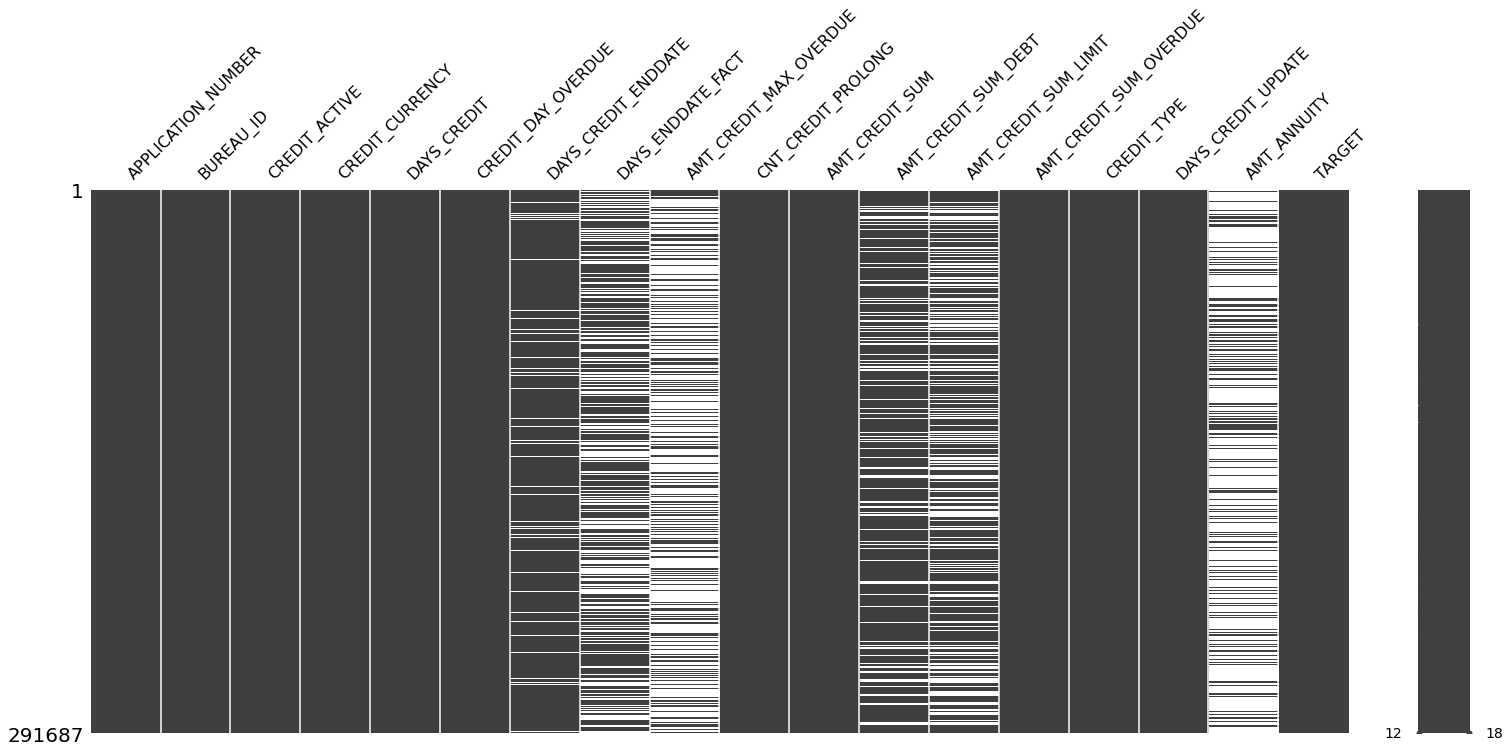

In [15]:
msno.matrix(data)

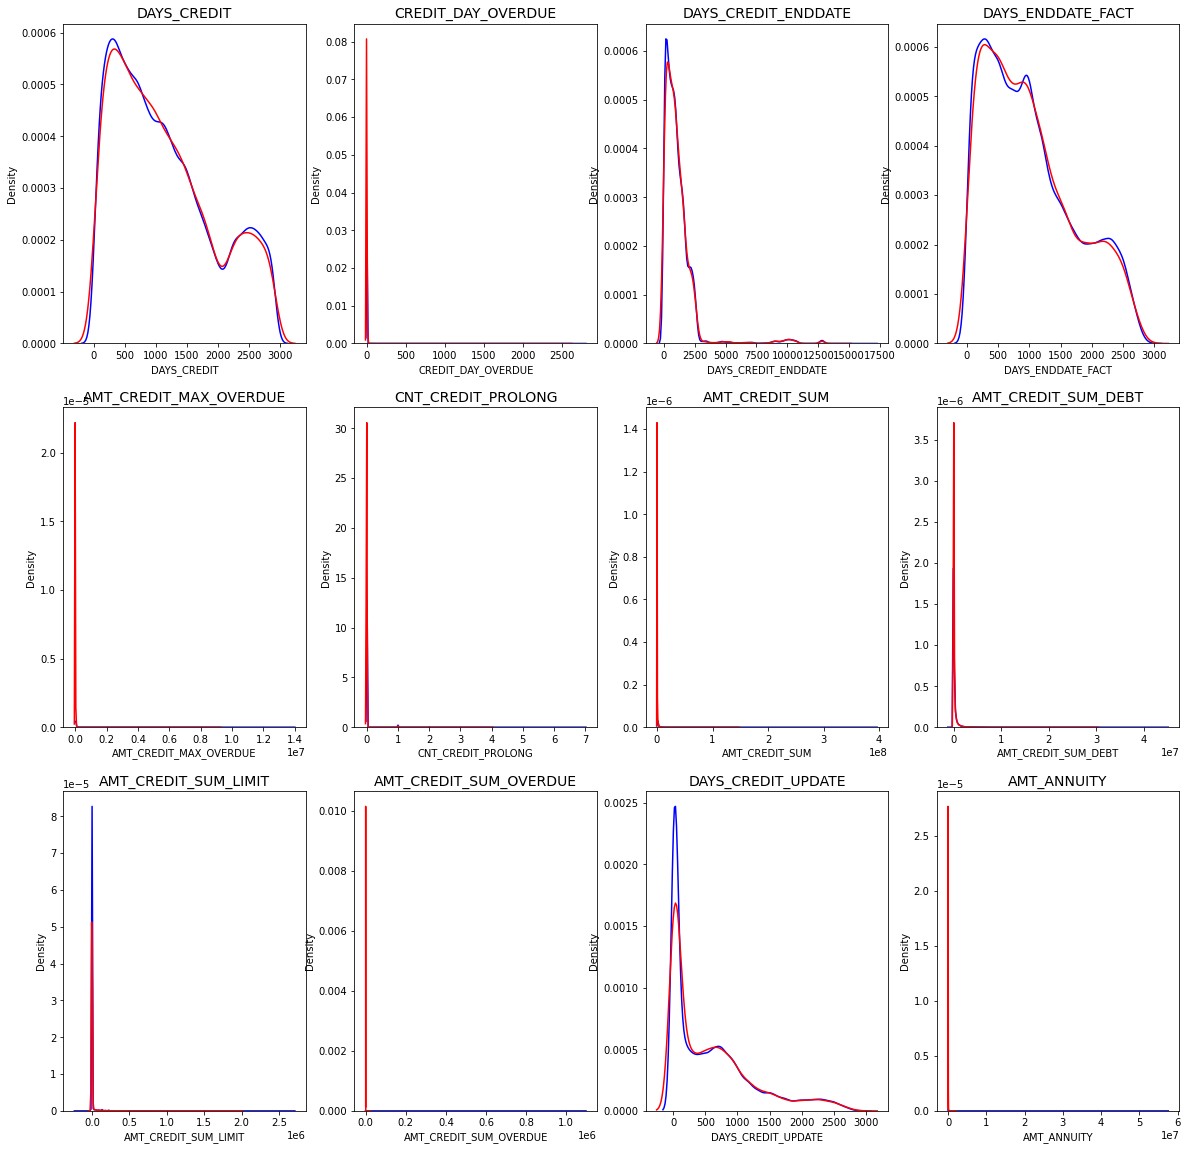

In [16]:
fig, axes = plt.subplots(3, 4, figsize=(20, 20))

for num, feature in enumerate(numerical_features):
    try:
        train_target_0, test_target_1 = data[data['TARGET']==0][feature].copy(), data[data['TARGET']==1][feature].copy()
        sns.kdeplot(train_target_0, ax=axes[num//4, num%4], color="blue", label="target=0")
        sns.kdeplot(test_target_1, ax=axes[num//4, num%4], color="red", label="target=1")
    except RuntimeError:
        pass
    except KeyError:
        pass
    axes[num//4, num%4].set_title(feature, fontsize=14)

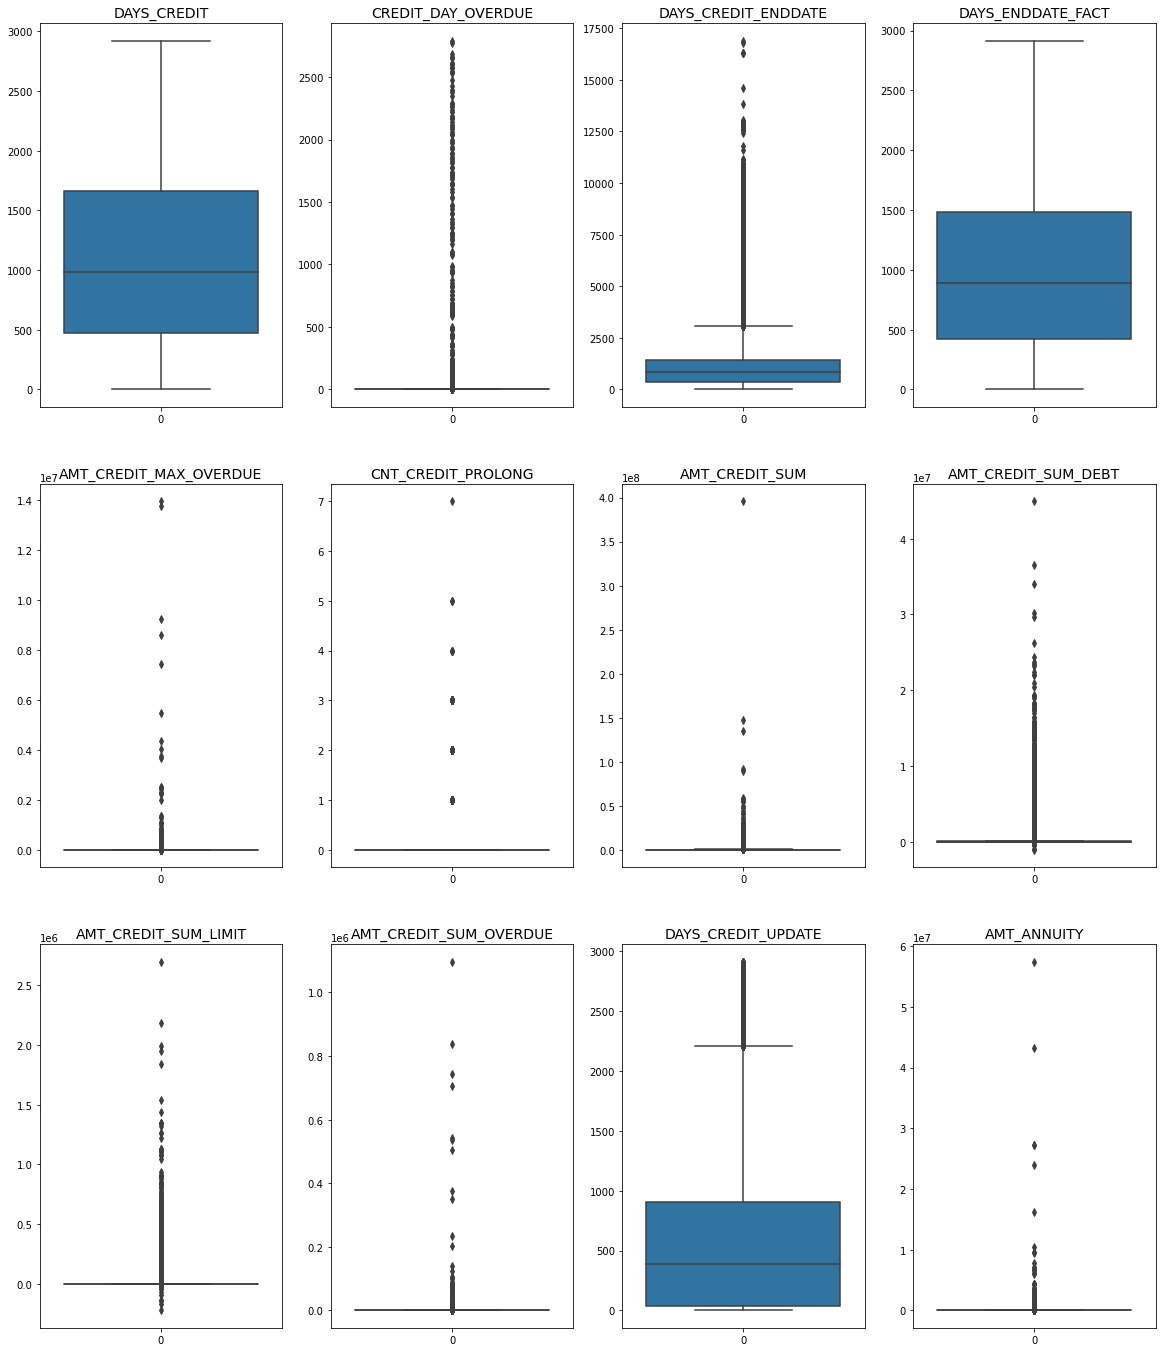

In [17]:
fig, axes = plt.subplots(3, 4, figsize=(20, 24))

for num, feature in enumerate(numerical_features):
    try:
        sns.boxplot(data=data[feature], ax=axes[num//4, num%4])
    except RuntimeError:
        pass
    except KeyError:
        pass
    axes[num//4, num%4].set_title(feature, fontsize=14)

In [18]:
correlation = data.corr()

<AxesSubplot:>

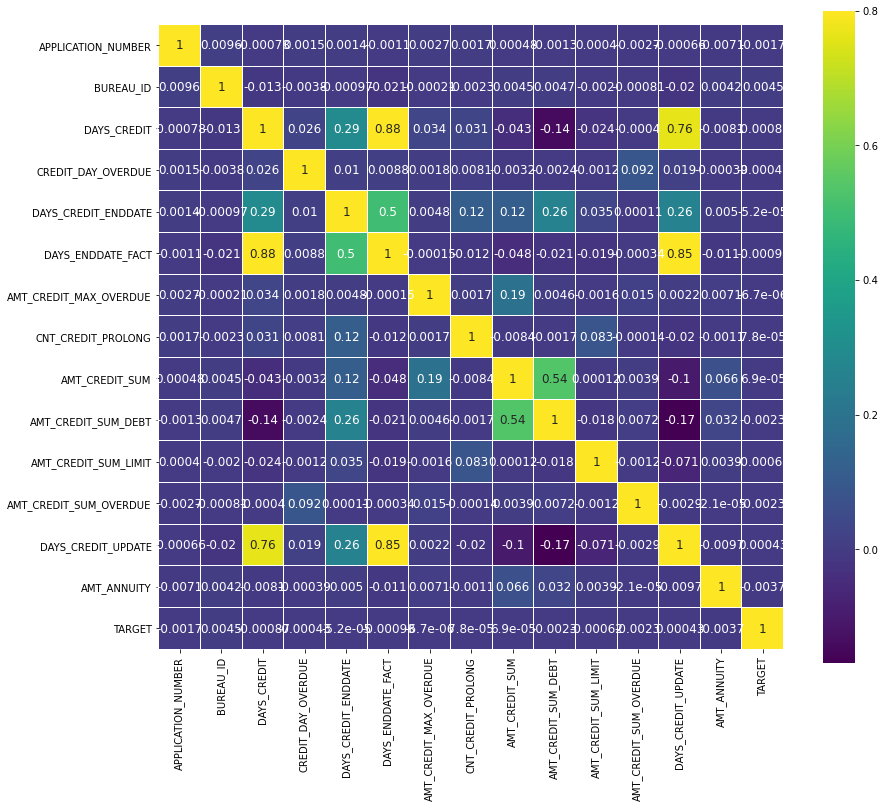

In [19]:
fig, axes = plt.subplots(figsize = (14, 12))
sns.heatmap(
    correlation,
    vmax=0.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    xticklabels=correlation.columns,
    annot_kws = {"size": 12},
    yticklabels=correlation.columns
)